In [ ]:
import pandas as pd
from sklearn.feature_selection import  mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


**Считываем, формируем признаки и целевую**

In [ ]:
df = pd.read_csv('data_eda.csv')

# Должны исключить из признаков саму целевую переменную и SI - рассчитывается на основе параметров IC50 и CC50
X = df.drop(['CC50, mM', 'SI'], axis=1)
y = df['CC50, mM']

**Оценим зависимость признаков и целевой переменной с помощью Mutual Info**

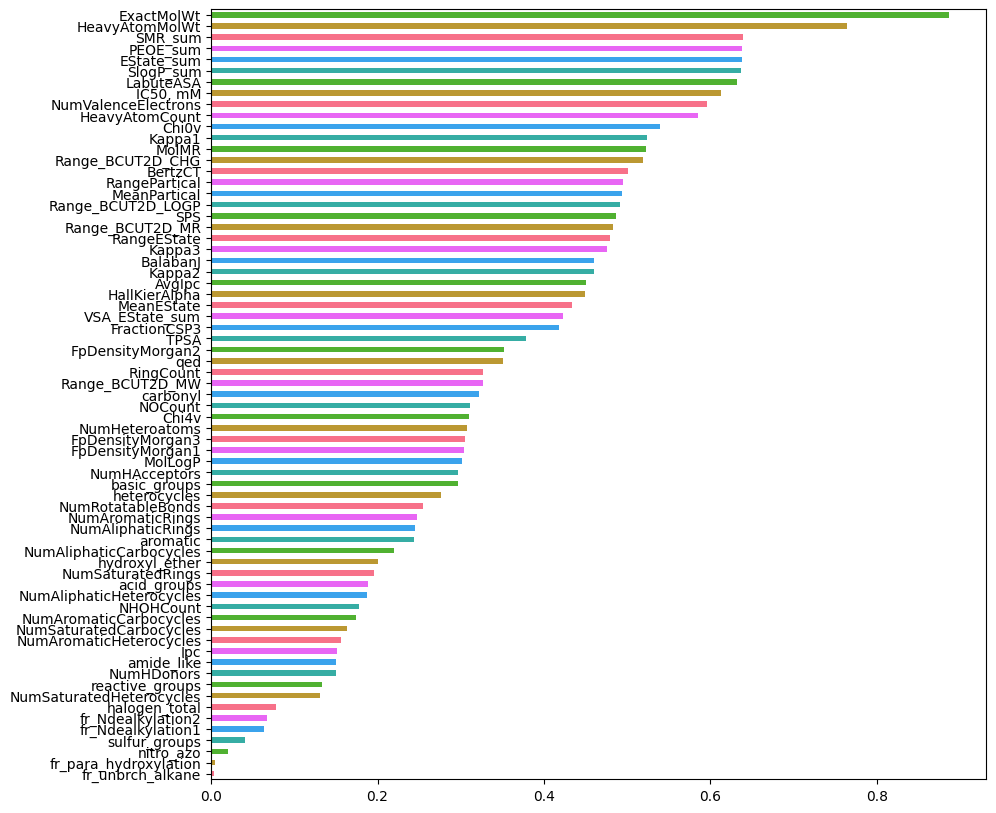

In [24]:
# Изучим зависимость признаков
importances = mutual_info_regression(X, y)

feature_importances = pd.Series(importances, X.columns[0:len(X.columns)])
feature_importances = feature_importances.sort_values()

colors = sns.color_palette("husl")
plt.figure(figsize=(10,10))
feature_importances.plot(kind='barh', color=colors)
plt.show()

**Уберем менее значимые признаки**

In [25]:
X.drop(columns=feature_importances.index[0:12], inplace=True)

**Делим данные на тестовые и тренировочные**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% данных в тест, 80% в трейн
    random_state=42,    # для воспроизводимости         
)

**Стандартизируем данные**

In [27]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train)

X_test_scaler = scaler.transform(X_test)

**Уменьшим количество признаков сохранив 97.5% дисперсии**

In [28]:
pca = PCA(n_components=0.975)  # 97.5%

X_train_pca = pca.fit_transform(X_train_scaler)

X_test_pca = pca.transform(X_test_scaler)

## **Модель линейной регрессии**

In [29]:
# Создадим модель
lig_reg = LinearRegression()
lig_reg.fit(X_train_pca, y_train)

# Предсказываем значения
y_pred = lig_reg.predict(X_test_pca)

# Считаем метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}\nMean Squared Error: {mse:.3f}\nRoot Mean Squared Error: {rmse:.3f}\nКоэффициент детерминации: {r2:.3f}")

Mean Absolute Error: 0.966
Mean Squared Error: 1.545
Root Mean Squared Error: 1.243
Коэффициент детерминации: 0.426


> **Mean Absolute Error (MAE) = 0.966**

Средняя абсолютная ошибка показывает, что в среднем предсказания модели отклоняются от фактических значений на 0.966 единицы.

> **Mean Squared Error (MSE) = 1.545**

Среднеквадратичная ошибка усиливает влияние больших ошибок за счет возведения в квадрат. Её значение 1.545 указывает на наличие отдельных значительных отклонений

> **Root Mean Squared Error (RMSE) = 1.243**

Корень из MSE, интерпретируемый в исходных единицах измерения, показывает, что стандартное отклонение ошибок составляет 1.243. Это выше MAE, что подтверждает неустойчивость модели на части данных

> **Коэффициент детерминации (R²) = 0.426**

Модель объясняет почти 43% дисперсии целевой переменной, что указывает на умеренное качество

> **Необходимо продолжить поиск наилучшей модели!**


## **Модель KNeighborsRegressor**

In [ ]:
# Определяем модель
model = KNeighborsRegressor()

# Задаем сетку гиперпараметров для перебора
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],  # количество соседей
    'weights': ['uniform', 'distance'],  # способ взвешивания соседей
    'p': [1, 2],  # метрика 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # алгоритм поиска соседей
}

# Создаем GridSearchCV объект
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

# Запускаем поиск
grid_search.fit(X_train_pca, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


In [31]:
# Переменная для лучшей модели
best_knn = grid_search.best_estimator_

# Предсказываем значения
y_pred = best_knn.predict(X_test_pca)

# Считаем метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}\nMean Squared Error: {mse:.3f}\nRoot Mean Squared Error: {rmse:.3f}\nКоэффициент детерминации: {r2:.3f}")

Mean Absolute Error: 0.802
Mean Squared Error: 1.271
Root Mean Squared Error: 1.127
Коэффициент детерминации: 0.528


**Модели показали схожую эффективность:**

MAE и RMSE у KNeighborsRegressor немного ниже, чем у линейной регрессии, что указывает на чуть лучшую точность.

Коэффициент детерминации (R²) около 53%, что говорит об умеренной объясняющей способности

KNeighborsRegressor немного превосходит линейную регрессию по всем метрикам, но разница незначительна

Для улучшения результатов стоит рассмотреть более сложные модели

## **Модель SVR**

In [32]:
# Создание модели SVR
svr = SVR()

# Параметры для Grid Search
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.5, 1.0]
}

# Создание Grid Search
grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Запуск Grid Search
grid_search.fit(X_train_pca, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'C': 10, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}


In [33]:
# Переменная для лучшей модели
best_svr = grid_search.best_estimator_

# Предсказываем значения
y_pred = best_svr.predict(X_test_pca)

# Считаем метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}\nMean Squared Error: {mse:.3f}\nRoot Mean Squared Error: {rmse:.3f}\nКоэффициент детерминации: {r2:.3f}")

Mean Absolute Error: 0.810
Mean Squared Error: 1.240
Root Mean Squared Error: 1.113
Коэффициент детерминации: 0.540


Модель показывает немного лучшие результаты по большинству метрик, что указывает на её чуть более высокую предсказательную способность.


Средняя абсолютная ошибка (MAE) в обоих случаях составляет около 0.80–0.81, что означает, что прогнозы в среднем отклоняются от реальных значений на эту величину

Разница между MAE и RMSE в модели меньше, что говорит о меньшем количестве крупных ошибок по сравнению с первой

Коэффициент детерминации (0.540) выше, чем у первой (0.528), что подтверждает её лучшую способность объяснять изменчивость данных

## **Модель GradientBoostingRegressor**


In [34]:
# Создаем модель
gb = GradientBoostingRegressor(random_state=42)

# Определяем сетку параметров для поиска
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Создаем GridSearchCV объект
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2'
)

# Запускаем поиск по сетке
grid_search.fit(X_train_pca, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}


In [35]:
# Переменная для лучшей модели
best_gb = grid_search.best_estimator_

# Предсказываем значения
y_pred = best_gb.predict(X_test_pca)

# Считаем метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}\nMean Squared Error: {mse:.3f}\nRoot Mean Squared Error: {rmse:.3f}\nКоэффициент детерминации: {r2:.3f}")

Mean Absolute Error: 0.854
Mean Squared Error: 1.357
Root Mean Squared Error: 1.165
Коэффициент детерминации: 0.496


Хуже предсказательная точность – MAE (0.854 vs 0.810) и RMSE (1.165 vs 1.113) выше, что означает большие ошибки в прогнозах

Снижение объясняющей способности – R² (0.496 vs 0.540)

Увеличение MSE (1.357 vs 1.240)

Менее стабильные результаты – Все метрики ухудшились, что говорит о том, что модель SVR остается в приоретете

## **Модель RandomForestRegressor**

In [36]:
# Создание модели
rf = RandomForestRegressor(random_state=42)

# Параметры для Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [None, 10, 20, 30],  # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # Минимальное число образцов для разделения узла
    'min_samples_leaf': [1, 2, 4],    # Минимальное число образцов в листе
    'max_features': ['sqrt']   # Количество признаков для поиска лучшего разбиения
}

# Настройка Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5, 
    n_jobs=-1,  
    scoring='r2',
    error_score='raise')

# Запуск Grid Search
grid_search.fit(X_train_pca, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [37]:
# Переменная для лучшей модели
best_rf = grid_search.best_estimator_

# Предсказываем значения
y_pred = best_rf.predict(X_test_pca)

# Считаем метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}\nMean Squared Error: {mse:.3f}\nRoot Mean Squared Error: {rmse:.3f}\nКоэффициент детерминации: {r2:.3f}")

Mean Absolute Error: 0.856
Mean Squared Error: 1.255
Root Mean Squared Error: 1.120
Коэффициент детерминации: 0.534


> **Модель RandomForestRegressor показала себя хуже по всем метрикам**

**Наилучшие результаты показала модель SVR! Выбираем ее в качестве окончательной**

Её ключевое преимущество — гибкость настройки через выбор ядра и параметров регуляризации, что позволяет адаптироваться к различным типам данных

Однако производительность SVR сильно зависит от подбора гиперпараметров, что может требовать дополнительных вычислительных ресурсов

В целом, SVR является мощным инструментом для прогнозирования, особенно когда важна устойчивость к выбросам и сложным закономерностям.